# CS6700: Tutorial 3 - Policy Iteration

In [1]:
import numpy as np
from enum import Enum
import copy

Consider a standard grid world, where only 4 (up, down, left, right) actions are allowed and the agent deterministically moves accordingly, represented as below. Here yellow is the start state and white is the goal state.

Say, we define our MDP as:
- S: 121 (11 x 11) cells 
- A: 4 actions (up, down, left, right)
- P: Deterministic transition probability
- R: -1 at every step
- gamma: 0.9

Our goal is to find an optimal policy (shown in right).



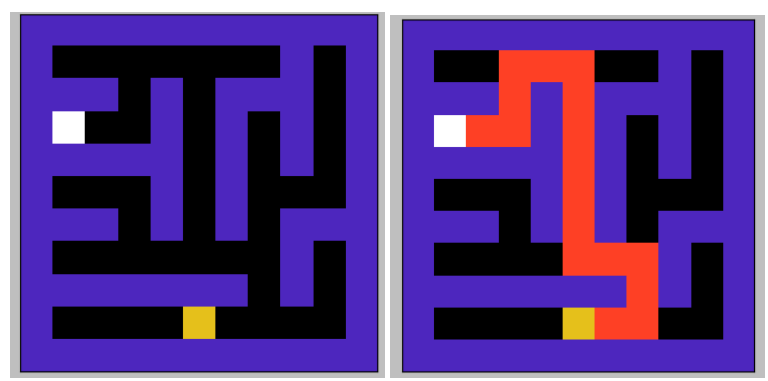

In [2]:
# Above grid is defined as below:
#   - 0 denotes an navigable tile
#   - 1 denotes an obstruction/wall
#   - 2 denotes the start state 
#   - 3 denotes an goal state

# Note: Here the upper left corner is defined as (0, 0)
#       and lower right corner as (m-1, n-1)

# Optimal Path: RIGHT RIGHT UP UP LEFT LEFT UP UP UP UP UP UP LEFT LEFT DOWN DOWN LEFT LEFT


GRID_WORLD = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1],
    [1, 3, 0, 0, 1, 0, 1, 0, 1, 0, 1],
    [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

### Actions

In [3]:
class Actions(Enum):
  UP    = (0, (-1, 0))  # index = 0, (xaxis_move = -1 and yaxis_move = 0)
  DOWN  = (1, (1, 0))   # index = 1, (xaxis_move = 1 and yaxis_move = 0) 
  LEFT  = (2, (0, -1))  # index = 2, (xaxis_move = 0 and yaxis_move = -1)
  RIGHT = (3, (0, 1))   # index = 3, (xaxis_move = 0 and yaxis_move = -1)

  def get_action_dir(self):
    _, direction = self.value
    return direction

  @property
  def index(self):
    indx, _ = self.value
    return indx

  @classmethod
  def from_index(cls, index):
    action_index_map = {a.index: a for a in cls}
    return action_index_map[index]

In [4]:
# How to use Action enum
for a in Actions:
  print(f"name: {a.name}, action_id: {a.index}, direction_to_move: {a.get_action_dir()}")

print("\n------------------------------------\n")

# find action enum from index 0
a = Actions.from_index(0)
print(f"0 index action is: {a.name}")

name: UP, action_id: 0, direction_to_move: (-1, 0)
name: DOWN, action_id: 1, direction_to_move: (1, 0)
name: LEFT, action_id: 2, direction_to_move: (0, -1)
name: RIGHT, action_id: 3, direction_to_move: (0, 1)

------------------------------------

0 index action is: UP


### Policy

In [5]:
class BasePolicy:
  def update(self, *args):
    pass

  def select_action(self, state_id: int) -> int:
    raise NotImplemented


class DeterministicPolicy(BasePolicy):
  def __init__(self, actions: np.ndarray):
    # actions: its a 1d array (|S| size) which contains action for each state
    self.actions = actions

  def update(self, state_id, action_id):
    assert state_id < len(self.actions), f"Invalid state_id {state_id}"
    assert action_id < len(Actions), f"Invalid action_id {action_id}"
    self.actions[state_id] = action_id

  def select_action(self, state_id: int) -> int:
    assert state_id < len(self.actions), f"Invalid state_id {state_id}"
    return self.actions[state_id]

### Environment

In [6]:
class Environment:
  def __init__(self, grid):
    self.grid = grid
    m, n = grid.shape
    self.num_states = m*n

  def xy_to_posid(self, x: int, y: int):
    _, n = self.grid.shape
    return x*n + y

  def posid_to_xy(self, posid: int):
    _, n = self.grid.shape
    return (posid // n, posid % n)

  def isvalid_move(self, x: int, y: int):
    m, n = self.grid.shape
    return (x >= 0) and (y >= 0) and (x < m) and (y < n) and (self.grid[x, y] != 1)

  def find_start_xy(self) -> int:
    m, n = self.grid.shape
    for x in range(m):
      for y in range(n):
        if self.grid[x, y] == 2:
          return (x, y)
    raise Exception("Start position not found.")

  def find_path(self, policy: BasePolicy) -> str:
    max_steps = 50
    steps = 0

    P, R = self.get_transition_prob_and_expected_reward()
    num_actions, num_states = R.shape
    all_possible_state_posids = np.arange(num_states)

    path = ""
    curr_x, curr_y = self.find_start_xy()
    while (self.grid[curr_x, curr_y] != 3) and (steps < max_steps):
      curr_posid = self.xy_to_posid(curr_x, curr_y)
      action_id = policy.select_action(curr_posid)
      next_posid = np.random.choice(
          all_possible_state_posids, p=P[action_id, curr_posid])
      action = Actions.from_index(action_id)
      path += f" {action.name}"
      curr_x, curr_y = self.posid_to_xy(next_posid)
      steps += 1
    return path

  def get_transition_prob_and_expected_reward(self):  # P(s_next | s, a), R(s, a)
    m, n = self.grid.shape
    num_states = m*n
    num_actions = len(Actions)
    P = np.zeros((num_actions, num_states, num_states))
    R = np.zeros((num_actions, num_states))
    for a in Actions:
      for x in range(m):
        for y in range(n):
          xmove_dir, ymove_dir = a.get_action_dir()
          xnew, ynew = x + xmove_dir, y + ymove_dir  # find the new co-ordinate after the action a

          posid = self.xy_to_posid(x, y)
          new_posid = self.xy_to_posid(xnew, ynew)
  
          
          if self.grid[x, y] == 3:
            # the current state is a goal state
            P[a.index, posid, posid] = 1
            R[a.index, posid] = 0
          elif (self.grid[x, y] == 1) or (not self.isvalid_move(xnew, ynew)):
            # the current state is a block state or the next state is invalid
            P[a.index, posid, posid] = 1
            R[a.index, posid] = -1
          else:
            # action a is valid and goes to a new position
            P[a.index, posid, new_posid] = 1
            R[a.index, posid] = -1
    return P, R

### Policy Iteration

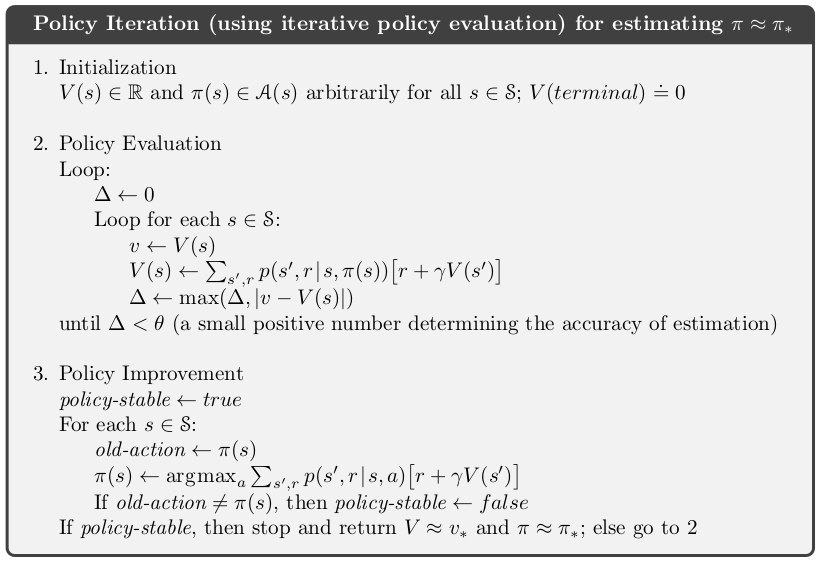

In [7]:
def policy_evaluation(P: np.ndarray, R: np.ndarray, gamma: float,
                      policy: BasePolicy, theta: float,
                      init_V: np.ndarray=None):
  _, num_states = R.shape

  # Please try different starting point for V you will find it will always
  # converge to the same V_pi value.
  
  if init_V is None:
    init_V = np.zeros(num_states)
    
  V = copy.deepcopy(init_V)

  delta = 100.0
  
  while delta > theta:
    delta = 0.0
    
    for state_id in range(num_states):
      
      action_id = policy.select_action(state_id)
      
      # Following equation is a different way of writing the same equation given in the slide.
      # Note here R is an expected reward term.
      V[state_id] = R[action_id, state_id] + gamma * np.dot(P[action_id, state_id], V)
      
      # YOUR CODE HERE
      delta = None # Calculate delta which determines when to terminate the evaluation step
      
  return V


def policy_improvement(P: np.ndarray, R: np.ndarray, gamma: float,
                      policy: BasePolicy, V: np.ndarray):
  _, num_states = R.shape
  policy_stable = True
  
  for state_id in range(num_states):
    
    old_action_id = policy.select_action(state_id)

    # YOUR CODE HERE
    new_action_id = 0 # update new_action_id based on the value function.

    policy.update(state_id, new_action_id)
    if old_action_id != new_action_id:
      policy_stable = False
      
  return policy_stable


def policy_iteration(P: np.ndarray, R: np.ndarray, gamma: float,
                    theta: float=1e-3, init_policy: BasePolicy = None):
  _, num_states = R.shape

  # Please try exploring different policies you will find it will always
  # converge to the same optimal policy for valid states.
  if init_policy is None:
    # Say initial policy = all up actions.
    init_policy = DeterministicPolicy(actions=np.zeros(num_states, dtype=int))

  # creating a copy of a initial policy
  policy = copy.deepcopy(init_policy)
  policy_stable = False
  
  while not policy_stable:
    V = policy_evaluation(P, R, gamma, policy, theta)
    policy_stable = policy_improvement(P, R, gamma, policy, V)
    
  return policy, V

### Experiments

In [8]:
def is_same_optimal_value(V1, V2, diff_theta=1e-3):
  diff = np.abs(V1 - V2)
  return np.all(diff < diff_theta)

In [9]:
seed = 0
np.random.seed(seed)

gamma = 0.9
theta = 1e-5

In [10]:
env = Environment(GRID_WORLD)
P, R = env.get_transition_prob_and_expected_reward()

#### Exercise 1: Using Policy iteration algorithm find the optimal path from start to goal position

In [11]:
# # Start with random choice of init_policy.
# One such choice could be: init_policy = np.ones(env.num_states, dtype=int)
init_policy = DeterministicPolicy(actions=np.ones(env.num_states, dtype=int))

pitr_policy, pitr_V_star = policy_iteration(P, R, gamma, theta=theta, init_policy=init_policy)
pitr_path = env.find_path(pitr_policy)
print(pitr_path)

 UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP UP


#### Exercise 2: Using initial guess for V as random values, find the optimal value function using policy evaluation and compare it with the optimal value function

In [12]:
# Start with random choice of init_V.
# One such choice could be: init_V = np.random.randn(env.num_states)
# Another choice could be: init_V = 10*np.ones(env.num_states)
init_V = 10*np.ones(env.num_states)

V_star = policy_evaluation(P, R, gamma, pitr_policy, theta, init_V)
is_same_optimal_value(pitr_V_star, V_star)

True

#### To-do: Repeat Exercise 1 with a random Deterministic policy